# Imports

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## sklearn

In [204]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn import feature_selection

## other

In [3]:
import scipy.stats as stats

# Custom Functions

## Model Evaluation Function
Function to create evaluation plots given test input

In [119]:
def lr_eval(model, X, y):
    # output r squared score for model
    print('R-squared:', model.score(X, y))
    
    # cacluate model residuals
    predictions = model.predict(X)
    residuals = y - predictions
    
    # evaluation plots
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7, 20))
    ax1.scatter(y, predictions)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Actual Value')
    ax1.set_ylabel('Predicted Value')
    ax2.scatter(predictions, residuals)
    ax2.set_title('Residual Plot')
    ax2.set_xlabel('Predicted Value')
    ax2.set_ylabel('Residual')
    stats.probplot(residuals, dist='norm', plot=plt);

# Data

In [4]:
filename = 'data/diamonds.csv'

In [5]:
n = sum(1 for line in open(filename)) - 1
s = 2000
random.seed(5)
skip = sorted(random.sample(range(1, n+1), n-s))
df = pd.read_csv(filename, skiprows=skip, index_col=0)

In [6]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
49,0.25,Very Good,E,VS2,63.3,60.0,404,4.00,4.03,2.54
66,0.28,Ideal,G,VVS2,61.4,56.0,553,4.19,4.22,2.58
79,0.26,Very Good,D,VVS2,62.8,60.0,554,4.01,4.05,2.53
120,0.80,Ideal,F,SI2,59.9,59.0,2762,6.01,6.07,3.62
188,0.71,Premium,F,VS2,62.1,58.0,2777,5.67,5.70,3.53


In [7]:
X_num = df.iloc[:, [0, 4, 5, 6, 7, 8]].copy()

In [8]:
y = X_num.pop('price')
y.head()

49      404
66      553
79      554
120    2762
188    2777
Name: price, dtype: int64

In [9]:
X_num.head()

,carat,depth,table,x,y
49,0.25,63.3,60.0,4.00,4.03
66,0.28,61.4,56.0,4.19,4.22
79,0.26,62.8,60.0,4.01,4.05
120,0.80,59.9,59.0,6.01,6.07
188,0.71,62.1,58.0,5.67,5.70


In [10]:
X_cat = df.iloc[:, [1, 2, 3]].copy()
X_cat.head()

,cut,color,clarity
49,Very Good,E,VS2
66,Ideal,G,VVS2
79,Very Good,D,VVS2
120,Ideal,F,SI2
188,Premium,F,VS2


## Column Definitions

carat (num): weight in carats (1 carat = 200 mg) (0.2--5.01)

cut (cat): quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color (cat): diamond color (J (worst) -- D (best))

clarity (cat): how obvious inclusions are within the diamond (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

depth (num): height of diamond, measured from the culet (bottom tip) to the table (top), divided by its average girdle (widest dimension) diameter = z / mean(x, y) (43--79)

table (num): width of diamond's table (top) expressed as a percentage of its average diameter

price (num): price in US dollars (326--18,823)

x (num): length in mm (0--10.74)

y (num): width in mm (0--58.9)

z (num): depth in mm (0--31.8)

# Diamond Dimensions
<img src = 'data/diamondanatomyimproved.jpg'>

## EDA

### Data Distributions

In [11]:
# sns.pairplot(df);

## Variable Distributions

### Carat Distribution

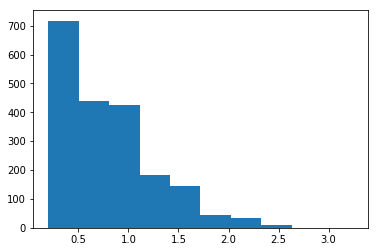

In [11]:
plt.hist(df['carat']);

### Price Distribution

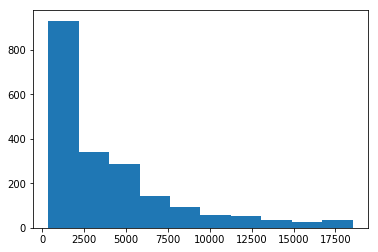

In [12]:
plt.hist(df['price']);

## Feature-Target Plots

### Carat vs Price

Text(0,0.5,'Price ($)')

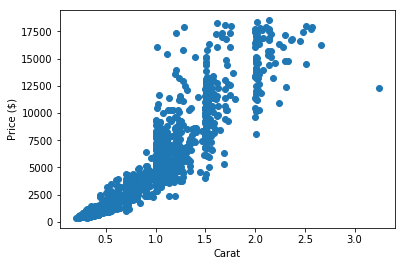

In [13]:
plt.scatter(df['carat'], df['price'])
plt.xlabel('Carat')
plt.ylabel('Price ($)')

# Pre-processing

## Categorical Data

### One-Hot Encoding
Encode categorical features as sparse matrix of categorical labels.

In [14]:
X_cat_enc = pd.get_dummies(X_cat)
X_cat_enc.head()

,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
49,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
66,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
79,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
120,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
188,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


### Oridnal
Encode categorical features as ordinal rank for each category.

In [15]:
X_cat_ord = X_cat.copy()

In [16]:
cut_ord = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_ord = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_ord = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
ord_list = [cut_ord, color_ord, clarity_ord]

In [17]:
# replace string feature labels with ordinal values
for i, column in enumerate(X_cat_ord.columns):
    
    # create label dictionary for each categorical feature
    label_dict = {}
    for j, label in enumerate(ord_list[i]):
        # map each label to ordinal value
        label_dict[label] = j
    
    # replace feature labels with ordinal values
    X_cat_ord[column] = X_cat_ord[column].map(label_dict)

In [18]:
X_cat.head()

,cut,color,clarity
49,Very Good,E,VS2
66,Ideal,G,VVS2
79,Very Good,D,VVS2
120,Ideal,F,SI2
188,Premium,F,VS2


In [19]:
X_cat_ord.head()

,cut,color,clarity
49,2,5,3
66,4,3,5
79,2,6,5
120,4,4,1
188,3,4,3


## Combine Numerical and Categorical Features

In [20]:
X = pd.concat([X_num, X_cat_enc], axis=1)
X.head()

,carat,depth,table,x,y,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
49,0.25,63.3,60.0,4.00,4.03,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
66,0.28,61.4,56.0,4.19,4.22,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
79,0.26,62.8,60.0,4.01,4.05,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
120,0.80,59.9,59.0,6.01,6.07,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
188,0.71,62.1,58.0,5.67,5.70,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## Test/Train Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling

In [125]:
lr = LinearRegression()

## Initial Model

In [126]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.9311490349026535

## Cross-validation

In [127]:
np.mean(cross_val_score(lr, X_train, y_train, cv=10))

0.9261137114096483

## Evaluation

In [128]:
lr.score(X_test, y_test)

0.9054174116393326

### Accuracy

In [129]:
predictions = lr.predict(X_test)

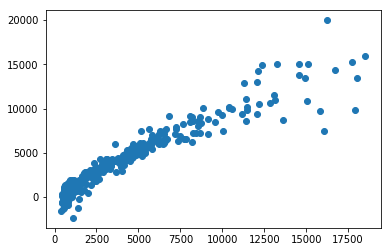

In [28]:
plt.scatter(y_test, predictions);

Plot shows some curvature as opposed to a straight line

### Residuals

In [29]:
residuals = y_test - predictions

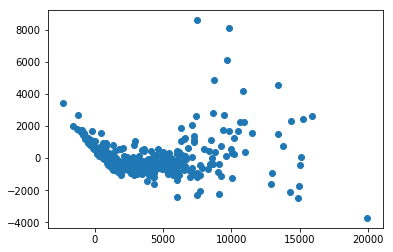

In [30]:
plt.scatter(predictions, residuals);

Plot shows lower bound due to target distribution (log-normal)

### Q-Q Plot

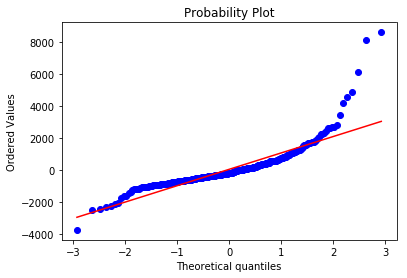

In [31]:
stats.probplot(residuals, dist="norm", plot=plt);

Points are bowed around red line indicating non-normal distribution of residuals

# Model Refinement

## Scaled Model
Transform all features to same scale.

In [101]:
lr_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

In [102]:
lr_pipe.fit(X_train, y_train)
np.mean(cross_val_score(lr_pipe, X_train, y_train, cv=10))

0.9261983733240566

In [103]:
lr_pipe.score(X_test, y_test)

0.9054174116393325

No difference in score

## Select Best Features
Select optimal features for model performance.

In [253]:
k_0 = 1

In [254]:
# input score method and number of features for selector
feat_selector = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=k_0)

In [255]:
lr_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('kbest', feat_selector),
    ('model', LinearRegression())
])

In [256]:
lr_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kbest', SelectKBest(k=1, score_func=<function f_regression at 0x7f075fef99d8>)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [257]:
lr_pipe.score(X_train, y_train)

0.8618503313047021

In [258]:
lr_pipe.score(X_test, y_test)

0.8236920526295299

In [259]:
max_test_score = lr_pipe.score(X_test, y_test)
best_k = k_0
k_range = range(1, len(X.columns)+1)
train_scores = []
test_scores = []

for i in k_range:
    lr_pipe.set_params(kbest__k=i)
    cv_mod = cross_validate(lr_pipe, X_train, y_train, cv=10, return_train_score=True)
    train_scores.append(np.mean(cv_mod['train_score']))
    test_scores.append(np.mean(cv_mod['test_score']))
    
    if np.mean(cv_mod['test_score']) > max_test_score:
        max_test_score = np.mean(cv_mod['test_score'])
        best_k = i

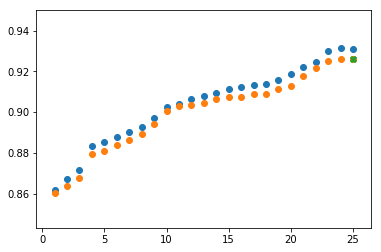

In [263]:
plt.scatter(k_range, train_scores)
plt.scatter(k_range, test_scores)
plt.scatter(best_k, max_test_score, marker='X')

In [261]:
best_k

25

In [221]:
cv_mod = cross_validate(lr_pipe, X_train, y_train, cv=10, return_train_score=True)

In [222]:
np.mean(cv_mod['train_score'])

0.8670550310689593

In [223]:
np.mean(cv_mod['test_score'])

0.8638369347993727

In [220]:
lr_pipe.set_params(kbest__k=2)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kbest', SelectKBest(k=2, score_func=<function f_regression at 0x7f075fef99d8>)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [195]:
# return parameters of items in pipeline
lr_pipe.steps

[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('kbest',
  SelectKBest(k=5, score_func=<function f_regression at 0x7f075fef99d8>)),
 ('model',
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]

In [196]:
lr_pipe.steps[1][1].transform(X_train)

array([[ 1.51, 59.  ,  7.26,  7.36,  0.  ],
       [ 1.04, 56.  ,  6.61,  6.54,  0.  ],
       [ 1.51, 56.  ,  7.44,  7.47,  0.  ],
       ...,
       [ 2.  , 57.  ,  7.88,  7.64,  1.  ],
       [ 0.3 , 58.  ,  4.3 ,  4.26,  0.  ],
       [ 0.31, 59.  ,  4.36,  4.38,  0.  ]])

In [203]:
X_train.columns[lr_pipe.steps[1][1].get_support()]

Index(['carat', 'table', 'x', 'y', 'clarity_SI2'], dtype='object')

In [191]:
X_train.head()

,carat,depth,table,x,y,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
25757,1.51,62.4,59.0,7.26,7.36,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6391,1.04,60.2,56.0,6.61,6.54,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
21286,1.51,60.6,56.0,7.44,7.47,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
18138,1.40,59.9,60.0,7.29,7.38,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
10915,1.01,63.0,57.0,6.28,6.35,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [189]:
pd.DataFrame(lr_pipe.steps[1][1].scores_, index=X_train.columns, columns=['Feature Score'])

,Feature Score
carat,9969.164910
depth,5.919624
table,21.568615
x,6194.077965
y,6378.189331
cut_Fair,0.066676
cut_Good,0.392503
cut_Ideal,4.289394
cut_Premium,2.145682
cut_Very Good,2.202350


## Log Transform of Feature Variable
Transform feature with apparent log-normal distribution to log scale.

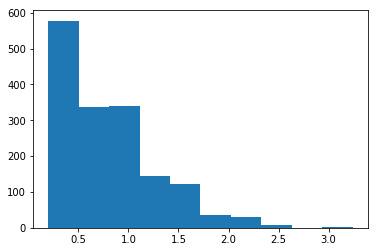

In [107]:
plt.hist(X_train['carat']);

In [108]:
X_train_ln = X_train.copy()
X_train_ln['carat'] = X_train_ln['carat'].apply(np.log)
X_test_ln = X_test.copy()
X_test_ln['carat'] = X_test_ln['carat'].apply(np.log)

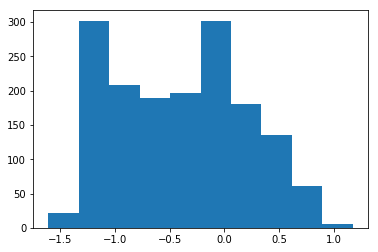

In [109]:
plt.hist(X_train_ln['carat']);

In [131]:
lr.fit(X_train_ln, y_train)
lr.score(X_train_ln, y_train)

0.9277634876512848

In [132]:
np.mean(cross_val_score(lr, X_train_ln, y_train, cv=10))

0.9240986328061174

R-squared: 0.8448333221773431


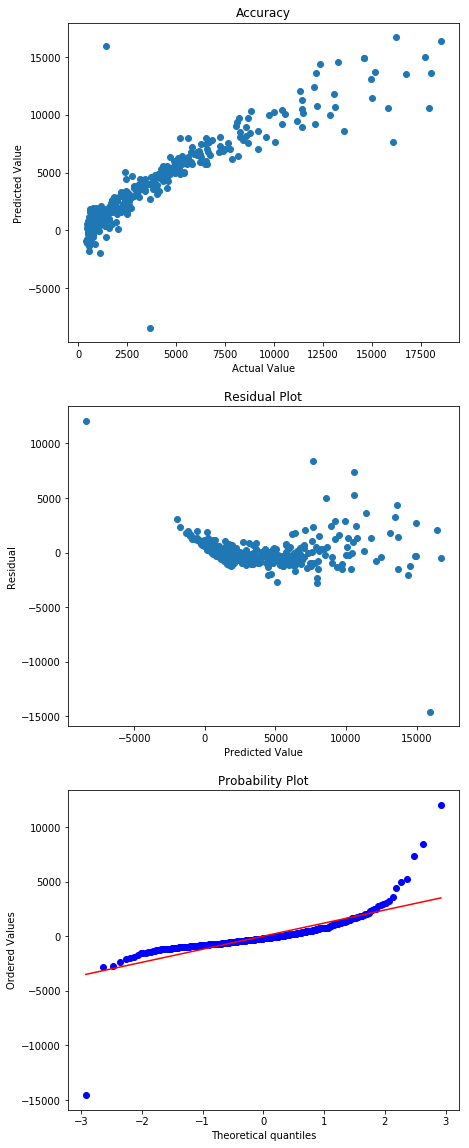

In [113]:
lr_pipe.fit(X_train_ln, y_train)
lr_eval(lr_pipe, X_test_ln, y_test)

Plots show issues with the fit of the model

## Log Transform of Target Variable
Transform target variable with apparent log-normal distribution to log scale.

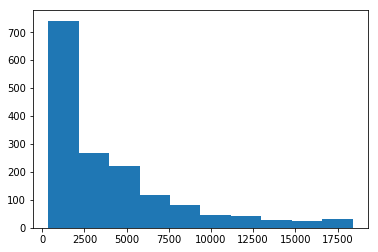

In [114]:
plt.hist(y_train);

In [115]:
y_train_ln = np.log(y_train)
y_test_ln = np.log(y_test)

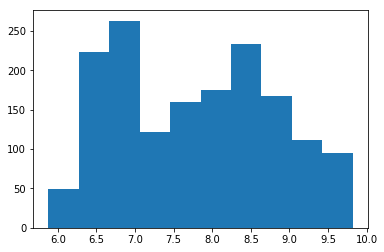

In [116]:
plt.hist(y_train_ln);

In [133]:
lr.fit(X_train, y_train_ln)
lr.score(X_train, y_train_ln)

0.9838526994234724

In [134]:
np.mean(cross_val_score(lr, X_train, y_train_ln, cv=10))

0.9831570392395325

R-squared: 0.9738929332263593


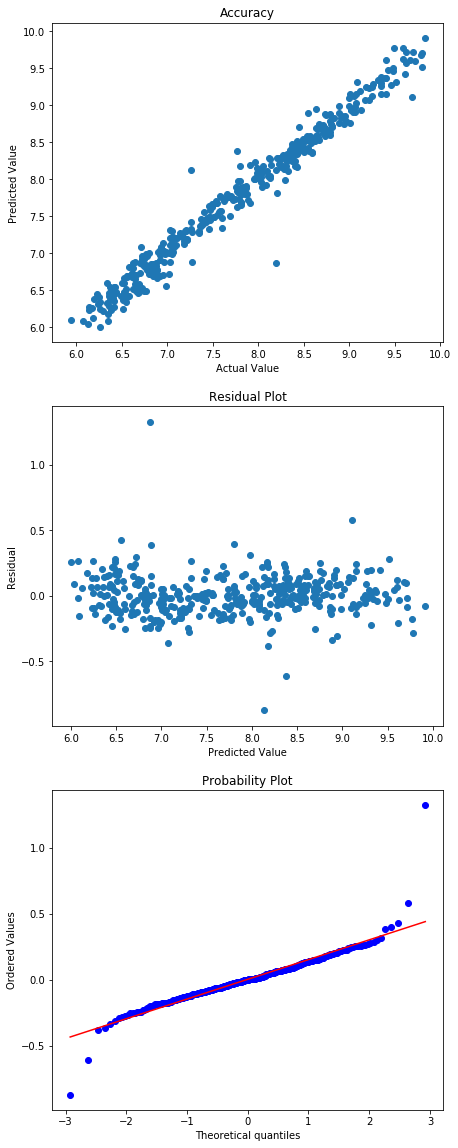

In [120]:
lr_pipe.fit(X_train, y_train_ln)
lr_eval(lr_pipe, X_test, y_test_ln)

Plots show significant improvement of model fit

## Polynomial Transformation of Feature Variables
Transform feature data to polynomial features so that it is better able to fit the training data.

In [121]:
lr_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('model', LinearRegression())
])

In [122]:
lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_train, y_train)

0.9951377529323292

In [123]:
np.mean(cross_val_score(lr_pipe, X_train, y_train, cv=10))

-4.641447759930986e+16

In [124]:
lr_pipe.score(X_test, y_test)

-11710685586632.078

## Regularization
Regularization is needed due to test score << training score.

In [135]:
alpha_range = np.linspace(0.001, 10, 10)

In [137]:
lr_ridge_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('model', linear_model.RidgeCV(alphas=alpha_range, cv=10, scoring='r2'))
])

In [138]:
lr_ridge_pipe.fit(X_train, y_train)
lr_ridge_pipe.score(X_train, y_train)

0.9825644733563605

In [ ]:
# output best alpha value for regularization
lr_ridge_pipe.steps[2][1].alpha_

R-squared: 0.9588320791738943


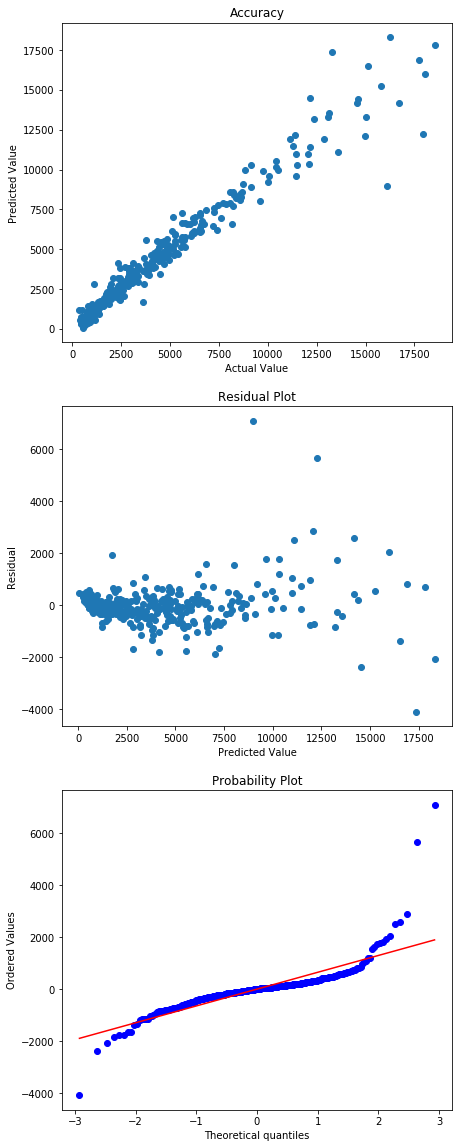

In [141]:
lr_eval(lr_ridge_pipe, X_test, y_test)

Good r-squared score but heteroskedasticity in residual plot and bowing in q-q plot.

# Final Model
Combine polynomial features and feature and target transformed to log scale for final model.

In [135]:
alpha_range = np.linspace(0.001, 10, 10)

In [137]:
lr_ridge_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('model', linear_model.RidgeCV(alphas=alpha_range, cv=10, scoring='r2'))
])

In [142]:
lr_ridge_pipe.fit(X_train_ln, y_train_ln)
lr_ridge_pipe.score(X_train_ln, y_train_ln)

0.9903797947314591

R-squared: 0.9824581918505233


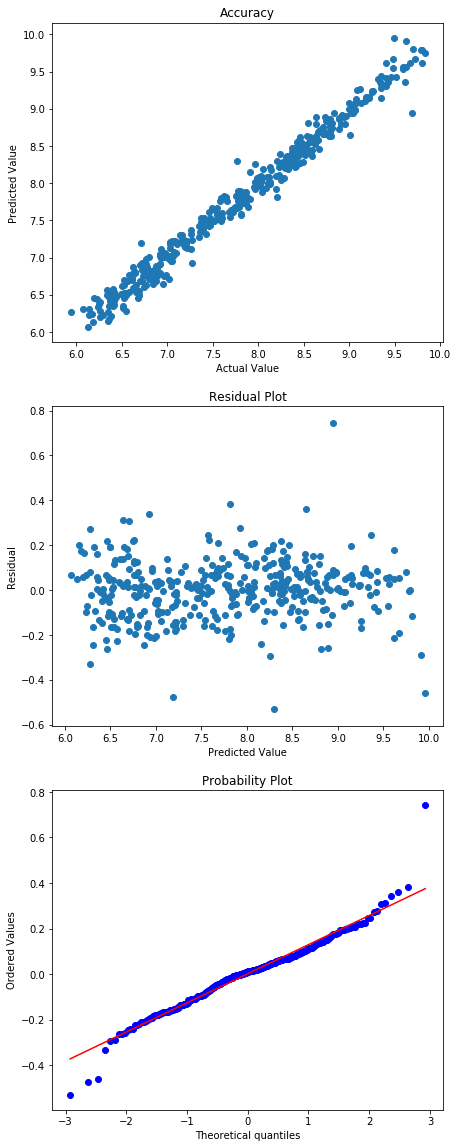

In [145]:
lr_eval(lr_ridge_pipe, X_test_ln, y_test_ln)

High test accuracy, normally distributed residuals and mostly aligned q-q plot.  
Values at tails veer off.

In [152]:
# output coefficients
lr_ridge_pipe.steps[2][1].coef_

array([0.        , 0.8124172 , 0.03650292, ..., 0.        , 0.        ,
       0.01570323])

In [259]:
# transform model predictions back to normal scale
predictions = np.exp(LR_ridge.predict(X_test_norm_poly))

# Model Interpretation

## Feature Selection

In [271]:
feat_selector = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k='all')
feat_selector.fit(X_train_norm, y_train_ln)

SelectKBest(k='all', score_func=<function f_regression at 0x7fcac0116bf8>)

In [272]:
feat_selector.scores_

array([9.61654054e+03, 4.93115529e+00, 4.37870631e+01, 2.06455987e+04,
       2.09492602e+04, 4.96651738e-01, 1.91892492e-01, 9.54151768e+00,
       2.96779018e+00, 1.57623620e+00, 6.15373825e+00, 1.40390895e+01,
       2.85342456e+00, 5.43207282e-02, 9.14345252e+00, 1.19579300e+01,
       1.36756834e+01, 1.91173827e+00, 1.05103767e+01, 1.98808675e+00,
       9.04744206e+01, 2.44321716e+00, 4.01776812e+00, 2.53832185e+01,
       1.36126811e+01])

In [276]:
pd.DataFrame(feat_selector.scores_, index=X.columns, columns=['Feature Score'])

,Feature Score
carat,9616.540543
depth,4.931155
table,43.787063
x,20645.598677
y,20949.260157
cut_Fair,0.496652
cut_Good,0.191892
cut_Ideal,9.541518
cut_Premium,2.967790
cut_Very Good,1.576236


## Coefficients

In [286]:
LR_ridge.coef_

array([0.        , 0.42315414, 0.06976633, ..., 0.        , 0.        ,
       0.01312545])